In [0]:
!pip install -q pyDOE

import tensorflow as tf
import numpy as np

#from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
import time
from pyDOE import lhs

np.random.seed(1234)
tf.set_random_seed(1234)
%matplotlib inline

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, XYT_S, S, XYT_VX, VX, XYT_VY, VY, XYT_f, layers, lb, ub, gamma, phi, K, relpermn):
        #XYT_initial, U_initial: where to enforce initial condition. X_initial is a 1D array (location), U_initial is 2D array
        #XYT_boundary, U_boundary: where to enforece boundary condition. X_boundary is a 2D array (location and time), U_boundary is 2D array
        #XYT_f: where to enforce physics equations

        #u is a 1 by 3 vector storing vx, vy and saturation
        
        self.lb = lb
        self.ub = ub
    
        self.gamma, self.phi, self.K, self.relpermn = gamma, phi, K, relpermn
        
        self.x_s = XYT_S[:,0:1]
        self.y_s = XYT_S[:,1:2]
        self.t_s = XYT_S[:,2:3]
        self.u_s = S
        
        self.x_vx = XYT_VX[:,0:1]
        self.y_vx = XYT_VX[:,1:2]
        self.t_vx = XYT_VX[:,2:3]
        self.u_vx = VX
        
        self.x_vy = XYT_VY[:,0:1]
        self.y_vy = XYT_VY[:,1:2]
        self.t_vy = XYT_VY[:,2:3]
        self.u_vy = VY
        
        self.x_f = XYT_f[:,0:1]
        self.y_f = XYT_f[:,1:2]
        self.t_f = XYT_f[:,2:3]
        
        self.layers = layers
        
        # Initialize NNs
        self.weights, self.biases = self.initialize_NN(layers)
        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        self.x_s_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.y_s_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.t_s_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.u_s_tf = tf.placeholder(tf.float32, shape=[None, 1])

        self.x_vx_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.y_vx_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.t_vx_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.u_vx_tf = tf.placeholder(tf.float32, shape=[None, 1])
        
        self.x_vy_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.y_vy_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.t_vy_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.u_vy_tf = tf.placeholder(tf.float32, shape=[None, 1])

        self.x_f_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.y_f_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.t_f_tf = tf.placeholder(tf.float32, shape=[None, 1])

        _, _, self.s_pred = self.net_u(self.x_s_tf,  self.y_s_tf,  self.t_s_tf)
        self.vx_pred,_,_  = self.net_u(self.x_vx_tf, self.y_vx_tf, self.t_vx_tf)
        _, self.vy_pred,_ = self.net_u(self.x_vy_tf, self.y_vy_tf, self.t_vy_tf)
        
        self.fp_pred, self.fs_pred, self.fv_pred = self.net_f(self.x_f_tf,self.y_f_tf,self.t_f_tf)
        
        self.loss_s  = tf.reduce_mean(tf.square(self.s_pred - self.u_s_tf)) #enforce initial saturation
        
        self.loss_vx = tf.reduce_mean(tf.square(self.vx_pred - self.u_vx_tf)) #enforce vx at left and right boundaries
        self.loss_vy = tf.reduce_mean(tf.square(self.vy_pred - self.u_vy_tf)) #enforce vx at top and bottom boundaries
                                        
        self.loss_fp = 2*tf.reduce_mean(tf.square(self.fp_pred))
        self.loss_fs = 2*tf.reduce_mean(tf.square(self.fs_pred))
        self.loss_fv = tf.reduce_mean(tf.square(self.fv_pred)) 
        
        self.loss = self.loss_s + self.loss_vx + self.loss_vy + self.loss_fp + self.loss_fs + self.loss_fv 
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 500,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 2.0 * np.finfo(float).eps})
        
        self.optimizer_Adam = tf.train.AdamOptimizer(learning_rate = 0.0004)
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)                    
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, XT, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(XT - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            #if (l<num_layers-6) and (l%2==0):
            #    H = tf.nn.leaky_relu(tf.add(tf.matmul(H, W), b))
            #else:
            H = tf.tanh(tf.add(tf.matmul(H, W), b))

        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        
        return Y
    
    def net_u(self, x, y, t):
        u = self.neural_net(tf.concat([x,y,t],1), self.weights, self.biases)
        return u[:,0:1], u[:,1:2], tf.sigmoid(u[:,2:3])
    
    def net_f(self, x, y, t):
        vx, vy, sw = self.net_u(x,y,t)
        
        sw_t = tf.gradients(sw,t)[0]
        
        #Q=-1 if x=-0.75, otherwise 0
        #Q_prod = -0.5*(tf.sign(x-0.72)+tf.sign(0.78-x))
        Q_prod = - 25*tf.exp(-500.0*(tf.pow(x-0.75,2)+tf.pow(y-0.75,2))) \
                 - 6*tf.exp(-500.0*(tf.pow(x+0.75,2)+tf.pow(y-0.75,2))) \
                 - 12*tf.exp(-500.0*(tf.pow(x-0.75,2)+tf.pow(y+0.75,2))) \
                 - 5*tf.exp(-500.0*(tf.pow(x+0.75,2)+tf.pow(y+0.75,2)))
        #Q_prod = - 5*tf.exp(-500.0*((x-0.75)*(x-0.75)+y*y))
        #Q_prod = - 5*tf.exp(-500.0*(tf.pow(x-0.75,2)))
                 
        #Qw = 1 if x=0.75, otherwise 0
        #Q_inj = 0.5*(tf.sign(x+0.78)+tf.sign(-0.72-x))
        #Q_inj = 5*tf.exp(-500.0*((x+0.75)*(x+0.75)+y*y))
        Q_inj = 48*tf.exp(-500.0*(tf.pow(x,2)+tf.pow(y,2)))
        
        #gamma(1-sw)^n+sw^n
        if self.relpermn==1:
            if self.gamma==1:
                mobility = 1
            else:
                mobility = self.gamma*(1-sw) + sw
        else:
            mobility = self.gamma*tf.pow(1-sw,self.relpermn)+tf.pow(sw,self.relpermn)

        Fw = tf.pow(sw, self.relpermn)/mobility
        Q_o = Q_prod*(1-Fw)
        Q_w = Q_inj + Q_prod*Fw
    
        #K = tf.sin(3.1415927*x)*0.9+1.0
        K = 1.1-tf.exp(-150*tf.pow(x+y-0.75,2)-20*tf.pow(x-y,2))

        p_eqn_LHS = tf.gradients(K*mobility*vx,x)[0]+tf.gradients(K*mobility*vy,y)[0]
        p_eqn_RHS = Q_inj + Q_prod

        s_eqn_LHS = self.phi*sw_t \
            + tf.gradients(K*tf.pow(sw,self.relpermn)*vx,x)[0] \
            + tf.gradients(K*tf.pow(sw,self.relpermn)*vy,y)[0]
        s_eqn_RHS = Q_w
        

        f_p = p_eqn_LHS - p_eqn_RHS
        f_s = s_eqn_LHS - s_eqn_RHS
        f_v = tf.gradients(vx,y)[0] - tf.gradients(vy,x)[0]
        
        return f_p, f_s, f_v
    
    def callback(self, loss, loss_s, loss_vx, loss_vy, loss_fp, loss_fs, loss_fv):
        self.iter += 1
        if (self.iter % 50 == 0):
            print('Iter: %05d, Loss: %.2e, s: %.3e, vx: %.3e, vy: %.3e, fp: %.3e, fs: %.3e, fv: %.3e' % \
                  (self.iter,  loss, loss_s, loss_vx, loss_vy, loss_fp, loss_fs, loss_fv))
        
    def train(self,nIter_adam):

        tf_dict = {self.x_s_tf : self.x_s,  self.y_s_tf : self.y_s,  self.t_s_tf : self.t_s,  self.u_s_tf : self.u_s,
                   self.x_vx_tf: self.x_vx, self.y_vx_tf: self.y_vx, self.t_vx_tf: self.t_vx, self.u_vx_tf: self.u_vx,
                   self.x_vy_tf: self.x_vy, self.y_vy_tf: self.y_vy, self.t_vy_tf: self.t_vy, self.u_vy_tf: self.u_vy,
                   self.x_f_tf: self.x_f, self.y_f_tf: self.y_f, self.t_f_tf: self.t_f}
        start_t= time.time()

        for it in range(nIter_adam):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 50 == 0:
                elapsed = time.time() - start_t
                loss_value = self.sess.run(self.loss, tf_dict)
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_value,  elapsed))
                start_t = time.time()
                
        self.iter = 0                                                                                                            
        self.optimizer.minimize(self.sess, 
                                feed_dict = tf_dict,         
                                fetches = [self.loss, self.loss_s, self.loss_vx, self.loss_vy, self.loss_fp, self.loss_fs, self.loss_fv], 
                                loss_callback = self.callback)        
                                    
          
    def predict(self, XYT):
        s  = self.sess.run(self.s_pred,  {self.x_s_tf: XYT[:,0:1], self.y_s_tf: XYT[:,1:2], self.t_s_tf: XYT[:,2:3]})
        vx = self.sess.run(self.vx_pred, {self.x_vx_tf:XYT[:,0:1], self.y_vx_tf:XYT[:,1:2], self.t_vx_tf:XYT[:,2:3]})
        vy = self.sess.run(self.vy_pred, {self.x_vy_tf:XYT[:,0:1], self.y_vy_tf:XYT[:,1:2], self.t_vy_tf:XYT[:,2:3]})
        fp = self.sess.run(self.fp_pred, {self.x_f_tf: XYT[:,0:1], self.y_f_tf: XYT[:,1:2], self.t_f_tf: XYT[:,2:3]})
        fs = self.sess.run(self.fs_pred, {self.x_f_tf: XYT[:,0:1], self.y_f_tf: XYT[:,1:2], self.t_f_tf: XYT[:,2:3]})
        fv = self.sess.run(self.fv_pred, {self.x_f_tf: XYT[:,0:1], self.y_f_tf: XYT[:,1:2], self.t_f_tf: XYT[:,2:3]})
        
        return vx, vy, s, fp, fs, fv

In [0]:
def computePressure(x,y,Px,Py):
    dx = x[1]-x[0]
    dy = y[1]-y[0]
    P_left = scipy.integrate.cumtrapz(Py[:,0],y,initial = 0).reshape((len(y)),1)
    P = scipy.integrate.cumtrapz(Px,x,axis=1, initial = 0)
    P = P + P_left.repeat(len(x),axis=1)
    P = P - P.mean()
    return P
    
    

In [0]:
def draw_prediction(t):

    x_star = np.linspace(-1,1,129)
    y_star = np.linspace(-1,1,129)
    X_star, Y_star = np.meshgrid(x_star, y_star)
    K = 1.1-np.exp(-150*(X_star+Y_star-0.75)**2-20*(X_star-Y_star)**2)

    XYT_star = np.c_[X_star.flatten(),Y_star.flatten(),t*np.ones((X_star.size,1))]

    xrange = [x_star[0],x_star[-1]]
    yrange = [x_star[0],x_star[-1]]
    
    vx_pred, vy_pred, s_pred, fp_pred, fs_pred, fv_pred = model.predict(XYT_star)
    VX_pred = vx_pred.reshape(X_star.shape)
    VY_pred = vy_pred.reshape(X_star.shape)
    
    S_pred = s_pred.reshape(X_star.shape)
    Fp_pred = fp_pred.reshape(X_star.shape)
    Fs_pred = fs_pred.reshape(X_star.shape)
    Fv_pred = fv_pred.reshape(X_star.shape)
    
    P_pred = computePressure(x_star,y_star,-VX_pred,-VY_pred)
    
    VX_pred, VY_pred = VX_pred*K, VY_pred*K
    
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(331)
    plt.pcolor(X_star, Y_star, VX_pred,cmap='jet')
    plt.colorbar()
    plt.xlabel('x'),plt.ylabel('y')
    plt.xlim(xrange), plt.ylim(yrange)
    plt.axis('equal')
    plt.title('Vx at time %f' % t)
    
    ax = fig.add_subplot(332)
    plt.pcolor(X_star, Y_star, VY_pred,cmap='jet')
    plt.colorbar()
    plt.xlabel('x'),plt.ylabel('y')
    plt.xlim(xrange), plt.ylim(yrange)
    plt.axis('equal')
    plt.title('Vy at time %f' % t)
    
    ax = fig.add_subplot(333)
    plt.pcolor(X_star, Y_star, np.sqrt(VY_pred**2+VX_pred**2),cmap='jet')
    plt.colorbar()
    plt.streamplot(x_star, y_star, VX_pred, VY_pred, color='w')
    plt.xlabel('x'),plt.ylabel('y')
    plt.xlim(xrange), plt.ylim(yrange)
    plt.axis('equal')
    plt.title('V at time %f' % t)


    ax = fig.add_subplot(334)
    plt.pcolor(X_star, Y_star, K,cmap='jet')
    plt.colorbar()
    plt.streamplot(x_star, y_star, VX_pred, VY_pred, color='w')
    plt.xlabel('x'),plt.ylabel('y')
    plt.xlim(xrange), plt.ylim(yrange)
    plt.axis('equal')
    plt.title('K')

    
    ax = fig.add_subplot(335)
    plt.pcolor(X_star, Y_star, S_pred,cmap='jet', vmin = 0, vmax = 1)
    plt.colorbar()
    plt.streamplot(x_star, y_star, VX_pred, VY_pred, color='w')
    plt.xlabel('x'),plt.ylabel('y')
    plt.xlim(xrange), plt.ylim(yrange)
    plt.axis('equal')
    plt.title('S at time %f' % t)
    
    ax = fig.add_subplot(336)
    plt.pcolor(X_star, Y_star, P_pred,cmap='jet')
    plt.colorbar()
    plt.streamplot(x_star, y_star, VX_pred, VY_pred, color='w')
    plt.xlabel('x'),plt.ylabel('y')
    plt.xlim(xrange), plt.ylim(yrange)
    plt.axis('equal')
    plt.title('pressure at time %f' % t)
    

    ax = fig.add_subplot(337)
    plt.pcolor(X_star, Y_star, Fp_pred,cmap='jet',vmin = np.percentile(Fp_pred,1),vmax = np.percentile(Fp_pred,99))
    plt.colorbar()
    plt.xlabel('x'),plt.ylabel('y')
    plt.xlim(xrange), plt.ylim(yrange)
    plt.axis('equal')
    plt.title('F pressure at time %f' % t)
    

    ax = fig.add_subplot(338)
    plt.pcolor(X_star, Y_star, Fs_pred,cmap='jet',vmin = np.percentile(Fs_pred,1),vmax = np.percentile(Fs_pred,99))
    plt.colorbar()
    plt.xlabel('x'),plt.ylabel('y')
    plt.xlim(xrange), plt.ylim(yrange)
    plt.axis('equal')
    plt.title('F saturation at time %f' % t)
    

    ax = fig.add_subplot(339)
    plt.pcolor(X_star, Y_star, Fv_pred,cmap='jet',vmin = np.percentile(Fv_pred,1),vmax = np.percentile(Fv_pred,99))
    plt.colorbar()
    plt.xlabel('x'),plt.ylabel('y')
    plt.xlim(xrange), plt.ylim(yrange)
    plt.axis('equal')
    plt.title('F velocity at time %f' % t)

    
    plt.show()
    

In [0]:
def fftIndgen(n):
    a = range(-(n//2-1), n//2+1)
    return a

def gaussian_random_field(Pk = lambda k : k**-3.0, n = 100):
    def Pk2(kx, ky):
        if kx == 0 and ky == 0:
            return 0.0
        return np.sqrt(Pk(np.sqrt(kx**2 + ky**2)))
    noise = np.fft.fft2(np.random.normal(size = (n, n)))
    amplitude = np.zeros((n,n))
    
    for i, kx in enumerate(fftIndgen(n)):
        for j, ky in enumerate(fftIndgen(n)):            
            amplitude[i, j] = Pk2(kx, ky)
    return np.fft.ifft2(noise * amplitude)


In [0]:
N_i = 32 #number of points to enforce on initial condition
N_b = 32 #number of points to enforce on boundary condition
N_f = 4096 #number of points to enforce on physics

#layers = [2, 20, 20, 20, 20, 1]
layers = [3, 128, 128, 64, 64, 64, 32, 32, 32, 3]
#layers = [2, 32, 32, 32, 32, 32, 2]
#layers = [2, 16, 32, 32, 32, 32, 64, 64, 32, 32, 32, 32, 8, 4, 2]

gamma, phi, K, relpermn = 0.5, 0.2, 1, 2

t = np.linspace(0,1,N_b)
x = np.linspace(-1,1,N_i)
y = np.linspace(-1,1,N_i)

X, Y, T = np.meshgrid(x, y, t)

(-1.0, 1.0, -1.0, 1.0)

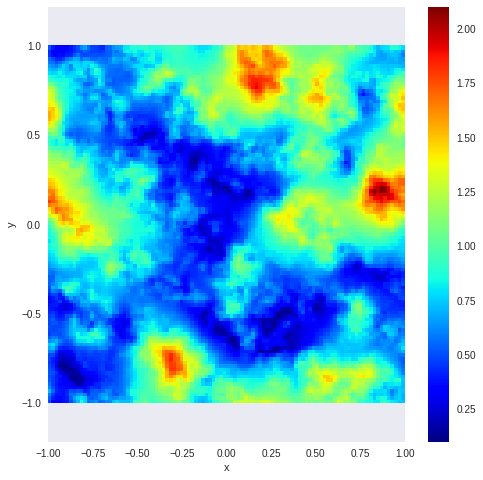

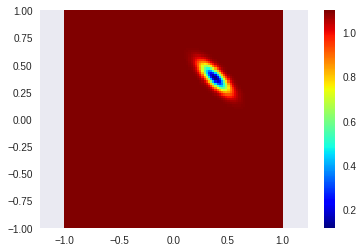

In [8]:
K = np.abs(gaussian_random_field(Pk = lambda k: k**-3.5, n=101))
K = (K - K.min())/(K.max()-K.min())*2.0+0.1
lnK = np.log(K)
x_K = np.linspace(-1,1,101)
y_K = np.linspace(-1,1,101)
X_K, Y_K = np.meshgrid(x_K,y_K)

plt.figure(figsize=(8,8))
plt.pcolor(X_K, Y_K, K, cmap='jet')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')

plt.colorbar()


plt.figure()
tmp_K = 1.1-np.exp(-150*(X_K+Y_K-0.75)**2-20*(X_K-Y_K)**2)
plt.pcolor(X_K,Y_K,tmp_K,cmap='jet')
plt.colorbar()
plt.axis('equal')

In [0]:
XYT_initial_S = np.c_[X[:,:,0].flatten(),Y[:,:,0].flatten(),T[:,:,0].flatten()]
S_initial = 0.3*np.ones((XYT_initial_S.shape[0],1))

LeftB = np.c_[X[:,0,:].flatten(),Y[:,0,:].flatten(),T[:,0,:].flatten()]
RightB = np.c_[X[:,-1,:].flatten(),Y[:,-1,:].flatten(),T[:,-1,:].flatten()]

XYT_boundary_VX = np.r_[LeftB,RightB]
VX_boundary = np.zeros((XYT_boundary_VX.shape[0],1))

TopB = np.c_[X[0,:,:].flatten(),Y[0,:,:].flatten(),T[0,:,:].flatten()]
BotB = np.c_[X[-1,:,:].flatten(),Y[-1,:,:].flatten(),T[-1,:,:].flatten()]

XYT_boundary_VY = np.r_[TopB,BotB]
VY_boundary = np.zeros((XYT_boundary_VY.shape[0],1))

In [10]:
lb = np.array([x.min(),y.min(),t.min()])
ub = np.array([x.max(),y.max(),t.max()])

#randomly sample points
XYT_f = lb + (ub-lb)*lhs(3, N_f)

#sample local refined points around wells
n_refine = 64
XY_nearWell = 0.25*lhs(2, n_refine)-0.125
XY_nearWell = np.r_[XY_nearWell+[-0.75,-0.75],XY_nearWell+[-0.75,0.75],XY_nearWell+[-0.75,-0.75],XY_nearWell+[+0.75,-0.75],XY_nearWell+[0.375,0.375],XY_nearWell]
T_nearWell = np.linspace(0,1,17).reshape(17,1).repeat(n_refine*6,axis=1).flatten()
XYT_nearWell = np.c_[XY_nearWell.repeat(17,axis=0),T_nearWell]

XYT_f = np.r_[XYT_initial_S, XYT_boundary_VX, XYT_boundary_VY, XYT_f, XYT_nearWell]
#XYT_f = np.r_[XYT_initial_S, XYT_boundary_VX, XYT_boundary_VY]

print('# points for initial condition : %d' % XYT_initial_S.shape[0])
print('# points for boundary condition: %d' % (XYT_boundary_VX.shape[0]+XYT_boundary_VY.shape[0]))
print('# points for physics: %d' % XYT_f.shape[0])
print('# points for well local refine: %d' % XYT_nearWell.shape[0])

# points for initial condition : 1024
# points for boundary condition: 4096
# points for physics: 15744
# points for well local refine: 6528


In [0]:
model = PhysicsInformedNN(XYT_initial_S,S_initial, XYT_boundary_VX, VX_boundary, XYT_boundary_VY, VY_boundary,
                          XYT_f, layers, lb, ub, gamma, phi, K, relpermn)

It: 0, Loss: 3.250e+01, Time: 3.70
It: 50, Loss: 2.361e+01, Time: 8.42
Iter: 00050, Loss: 2.47e+00, s: 3.481e-02, vx: 7.223e-03, vy: 2.496e-03, fp: 1.720e+00, fs: 6.442e-01, fv: 5.588e-02
Iter: 00100, Loss: 1.85e+00, s: 1.751e-02, vx: 5.991e-03, vy: 2.233e-03, fp: 1.564e+00, fs: 2.029e-01, fv: 5.433e-02
Iter: 00150, Loss: 1.58e+00, s: 2.603e-02, vx: 3.038e-03, vy: 9.983e-04, fp: 1.471e+00, fs: 5.525e-02, fv: 1.910e-02
Iter: 00200, Loss: 1.53e+00, s: 2.859e-02, vx: 2.761e-03, vy: 1.157e-03, fp: 1.431e+00, fs: 4.489e-02, fv: 2.101e-02
Iter: 00250, Loss: 1.47e+00, s: 2.892e-02, vx: 2.391e-03, vy: 1.389e-03, fp: 1.397e+00, fs: 2.742e-02, fv: 1.106e-02
Iter: 00300, Loss: 1.44e+00, s: 2.842e-02, vx: 2.086e-03, vy: 2.885e-03, fp: 1.370e+00, fs: 2.153e-02, fv: 1.060e-02
Iter: 00350, Loss: 1.41e+00, s: 2.766e-02, vx: 1.220e-03, vy: 2.071e-03, fp: 1.346e+00, fs: 1.874e-02, fv: 1.223e-02
Iter: 00400, Loss: 1.37e+00, s: 2.442e-02, vx: 1.828e-03, vy: 2.261e-03, fp: 1.313e+00, fs: 1.967e-02, fv: 1.2

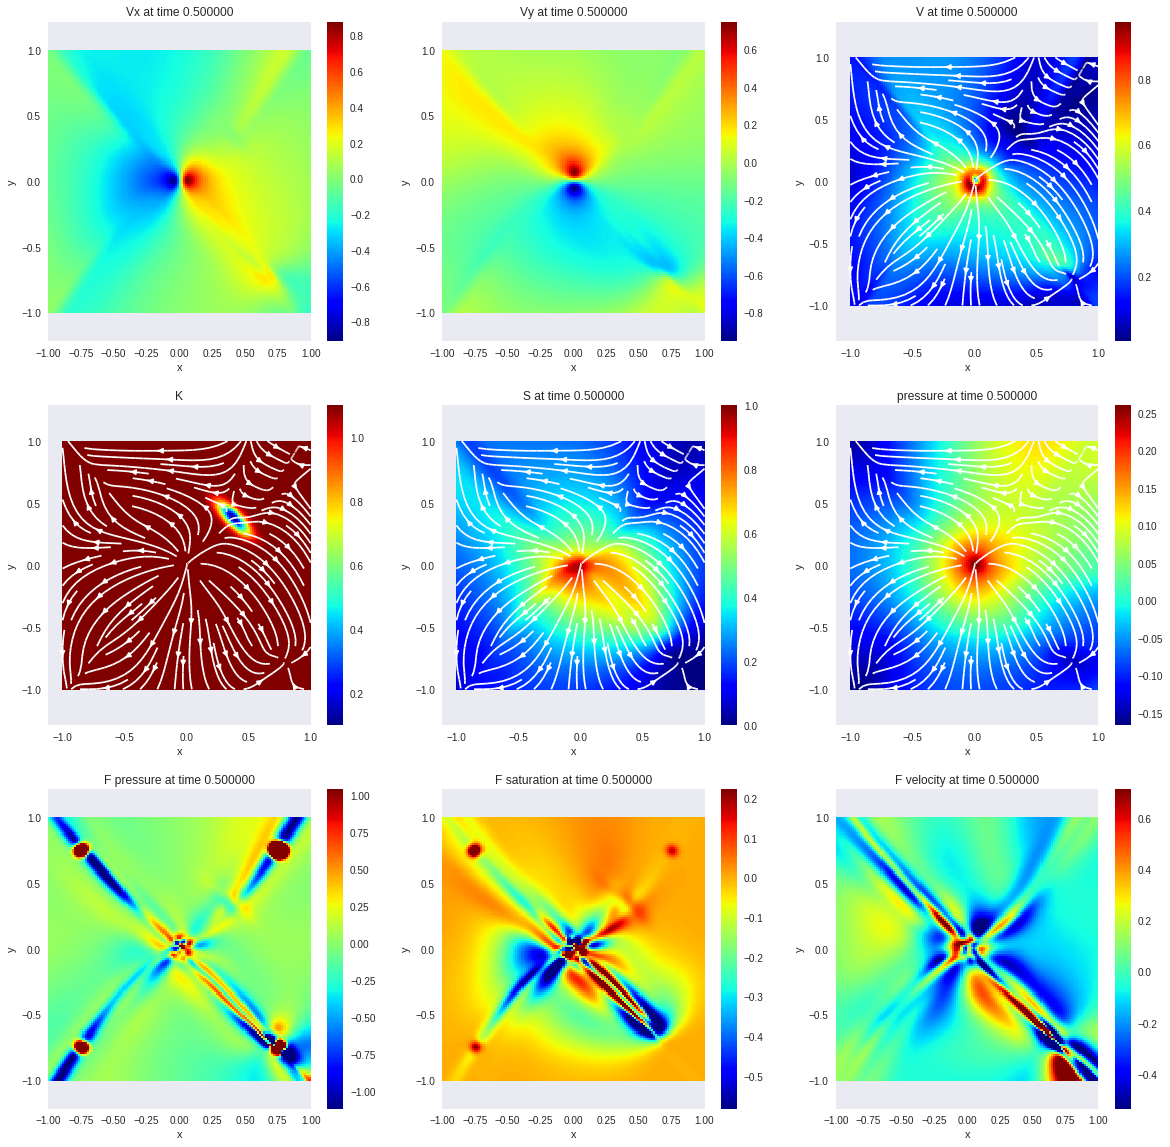

It: 0, Loss: 1.139e+00, Time: 0.25
It: 50, Loss: 1.099e+00, Time: 8.39
Iter: 00050, Loss: 8.78e-01, s: 3.051e-02, vx: 3.194e-03, vy: 5.245e-03, fp: 7.817e-01, fs: 2.827e-02, fv: 2.872e-02
Iter: 00100, Loss: 8.02e-01, s: 2.997e-02, vx: 1.555e-03, vy: 2.000e-03, fp: 7.253e-01, fs: 2.537e-02, fv: 1.795e-02
Iter: 00150, Loss: 7.68e-01, s: 2.992e-02, vx: 1.455e-03, vy: 1.405e-03, fp: 7.022e-01, fs: 2.014e-02, fv: 1.248e-02
Iter: 00200, Loss: 7.46e-01, s: 3.005e-02, vx: 1.471e-03, vy: 1.922e-03, fp: 6.851e-01, fs: 1.612e-02, fv: 1.094e-02
Iter: 00250, Loss: 7.26e-01, s: 2.952e-02, vx: 2.027e-03, vy: 2.490e-03, fp: 6.657e-01, fs: 1.453e-02, fv: 1.172e-02
Iter: 00300, Loss: 6.88e-01, s: 2.931e-02, vx: 1.624e-03, vy: 3.155e-03, fp: 6.199e-01, fs: 1.458e-02, fv: 1.900e-02
Iter: 00350, Loss: 5.89e-01, s: 2.898e-02, vx: 5.287e-03, vy: 8.787e-03, fp: 4.891e-01, fs: 1.640e-02, fv: 4.027e-02
Iter: 00400, Loss: 4.78e-01, s: 2.940e-02, vx: 3.747e-03, vy: 5.535e-03, fp: 3.788e-01, fs: 1.710e-02, fv: 4.3

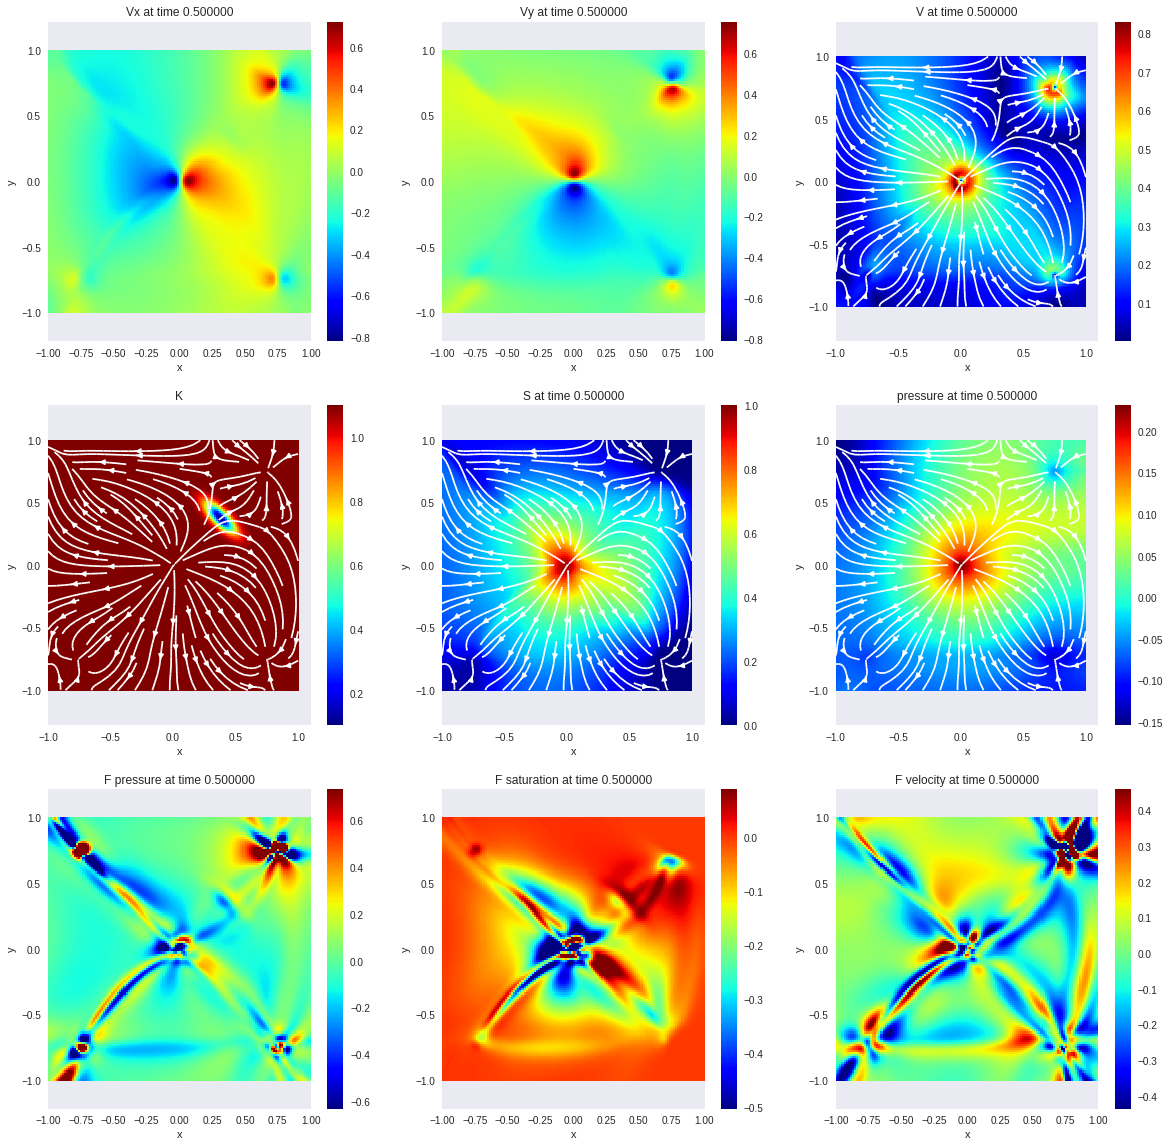

It: 0, Loss: 2.694e-01, Time: 0.25
It: 50, Loss: 2.582e-01, Time: 8.40
Iter: 00050, Loss: 2.13e-01, s: 2.836e-02, vx: 2.787e-03, vy: 2.028e-03, fp: 1.521e-01, fs: 1.274e-02, fv: 1.491e-02
Iter: 00100, Loss: 1.96e-01, s: 2.682e-02, vx: 2.442e-03, vy: 1.923e-03, fp: 1.411e-01, fs: 1.187e-02, fv: 1.203e-02
Iter: 00150, Loss: 1.84e-01, s: 2.611e-02, vx: 2.591e-03, vy: 2.357e-03, fp: 1.312e-01, fs: 1.153e-02, fv: 9.854e-03
Iter: 00200, Loss: 1.72e-01, s: 2.472e-02, vx: 2.454e-03, vy: 1.850e-03, fp: 1.194e-01, fs: 1.199e-02, fv: 1.149e-02
Iter: 00250, Loss: 1.54e-01, s: 2.313e-02, vx: 2.658e-03, vy: 2.515e-03, fp: 1.008e-01, fs: 1.244e-02, fv: 1.220e-02
Iter: 00300, Loss: 1.30e-01, s: 2.390e-02, vx: 2.883e-03, vy: 2.257e-03, fp: 7.260e-02, fs: 1.251e-02, fv: 1.563e-02
Iter: 00350, Loss: 1.07e-01, s: 2.297e-02, vx: 2.305e-03, vy: 2.775e-03, fp: 4.824e-02, fs: 1.285e-02, fv: 1.815e-02
Iter: 00400, Loss: 9.06e-02, s: 2.247e-02, vx: 1.939e-03, vy: 2.676e-03, fp: 3.570e-02, fs: 1.208e-02, fv: 1.5

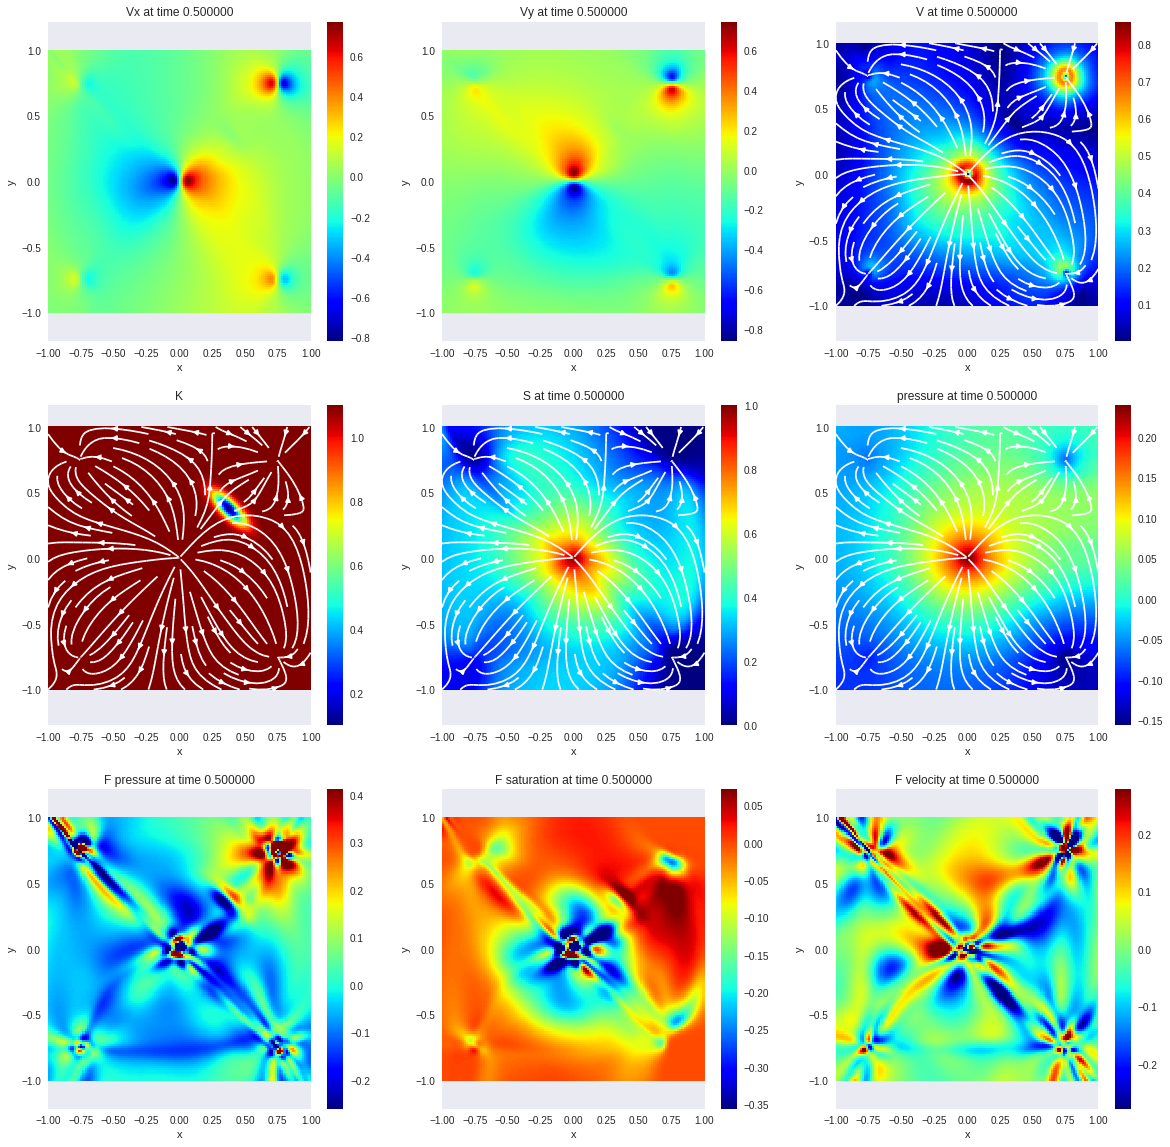

It: 0, Loss: 5.782e-02, Time: 0.26
It: 50, Loss: 5.655e-02, Time: 8.42
Iter: 00050, Loss: 5.21e-02, s: 1.956e-02, vx: 1.620e-03, vy: 1.784e-03, fp: 1.416e-02, fs: 9.597e-03, fv: 5.365e-03
Iter: 00100, Loss: 4.90e-02, s: 1.881e-02, vx: 1.436e-03, vy: 1.744e-03, fp: 1.262e-02, fs: 9.245e-03, fv: 5.166e-03
Iter: 00150, Loss: 4.66e-02, s: 1.747e-02, vx: 1.454e-03, vy: 1.734e-03, fp: 1.174e-02, fs: 9.258e-03, fv: 4.967e-03
Iter: 00200, Loss: 4.43e-02, s: 1.646e-02, vx: 1.450e-03, vy: 1.650e-03, fp: 1.148e-02, fs: 8.944e-03, fv: 4.347e-03
Iter: 00250, Loss: 4.26e-02, s: 1.599e-02, vx: 1.389e-03, vy: 1.566e-03, fp: 1.097e-02, fs: 8.648e-03, fv: 4.008e-03
Iter: 00300, Loss: 4.12e-02, s: 1.537e-02, vx: 1.362e-03, vy: 1.640e-03, fp: 1.086e-02, fs: 8.336e-03, fv: 3.680e-03
Iter: 00350, Loss: 3.95e-02, s: 1.485e-02, vx: 1.257e-03, vy: 1.688e-03, fp: 1.027e-02, fs: 7.922e-03, fv: 3.499e-03
Iter: 00400, Loss: 3.82e-02, s: 1.407e-02, vx: 1.268e-03, vy: 1.548e-03, fp: 9.965e-03, fs: 7.982e-03, fv: 3.4

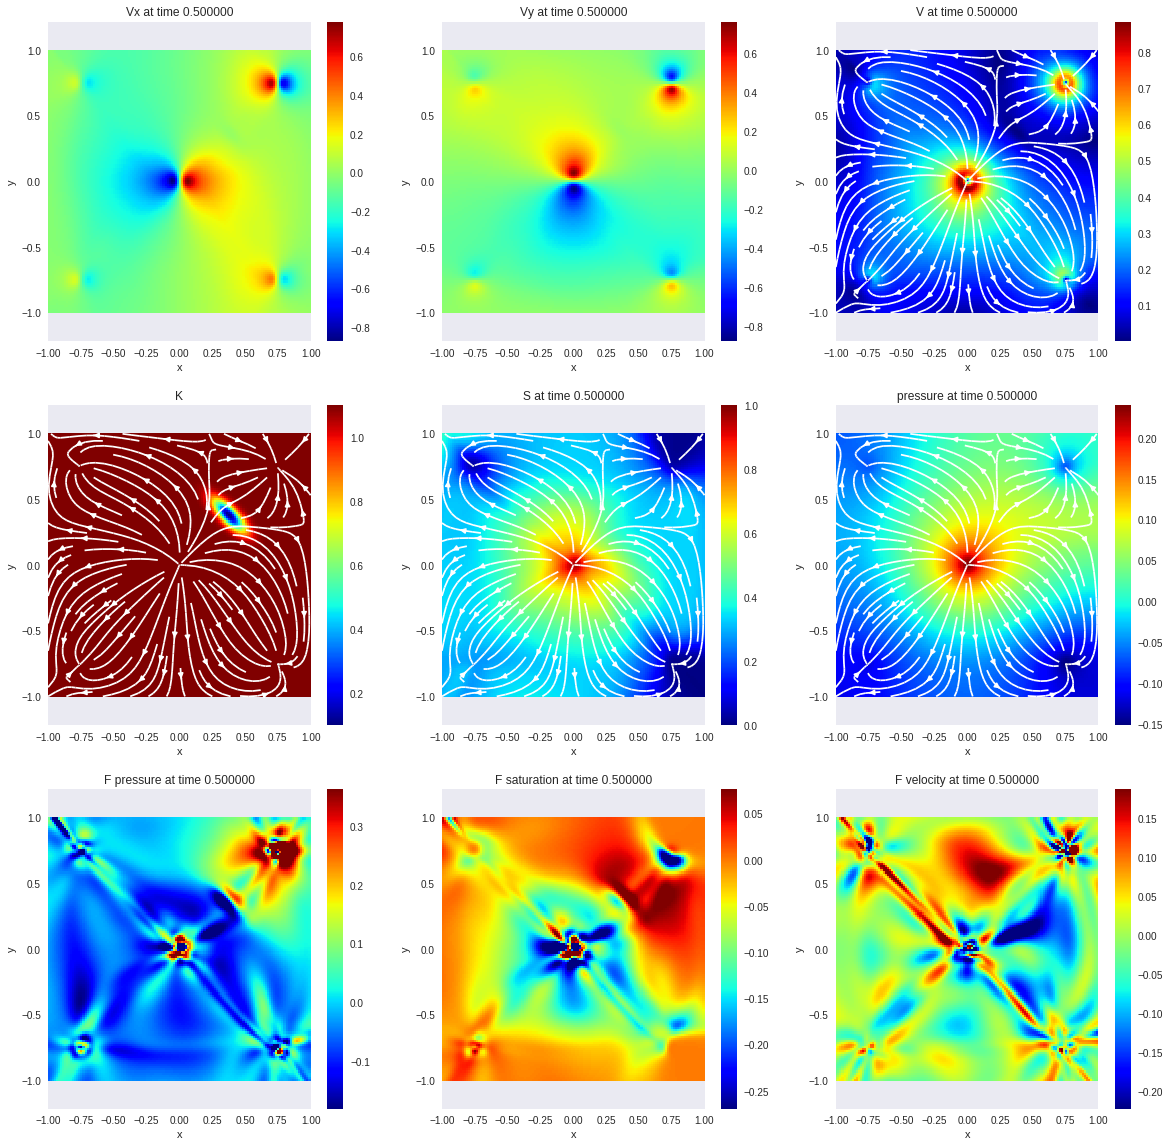

It: 0, Loss: 3.745e-02, Time: 0.27
It: 50, Loss: 3.650e-02, Time: 8.36
Iter: 00050, Loss: 3.42e-02, s: 1.254e-02, vx: 1.151e-03, vy: 1.582e-03, fp: 9.103e-03, fs: 7.261e-03, fv: 2.576e-03
Iter: 00100, Loss: 3.35e-02, s: 1.237e-02, vx: 1.154e-03, vy: 1.365e-03, fp: 9.066e-03, fs: 7.063e-03, fv: 2.447e-03
Iter: 00150, Loss: 3.27e-02, s: 1.204e-02, vx: 1.135e-03, vy: 1.344e-03, fp: 8.948e-03, fs: 6.878e-03, fv: 2.347e-03
Iter: 00200, Loss: 3.19e-02, s: 1.179e-02, vx: 1.191e-03, vy: 1.197e-03, fp: 8.845e-03, fs: 6.644e-03, fv: 2.275e-03
Iter: 00250, Loss: 3.13e-02, s: 1.131e-02, vx: 1.179e-03, vy: 1.161e-03, fp: 8.788e-03, fs: 6.506e-03, fv: 2.349e-03
Iter: 00300, Loss: 3.05e-02, s: 1.074e-02, vx: 1.158e-03, vy: 1.203e-03, fp: 8.623e-03, fs: 6.411e-03, fv: 2.341e-03
Iter: 00350, Loss: 2.97e-02, s: 1.009e-02, vx: 9.484e-04, vy: 1.195e-03, fp: 8.893e-03, fs: 6.319e-03, fv: 2.300e-03
Iter: 00400, Loss: 2.91e-02, s: 9.429e-03, vx: 1.037e-03, vy: 1.086e-03, fp: 8.991e-03, fs: 6.306e-03, fv: 2.2

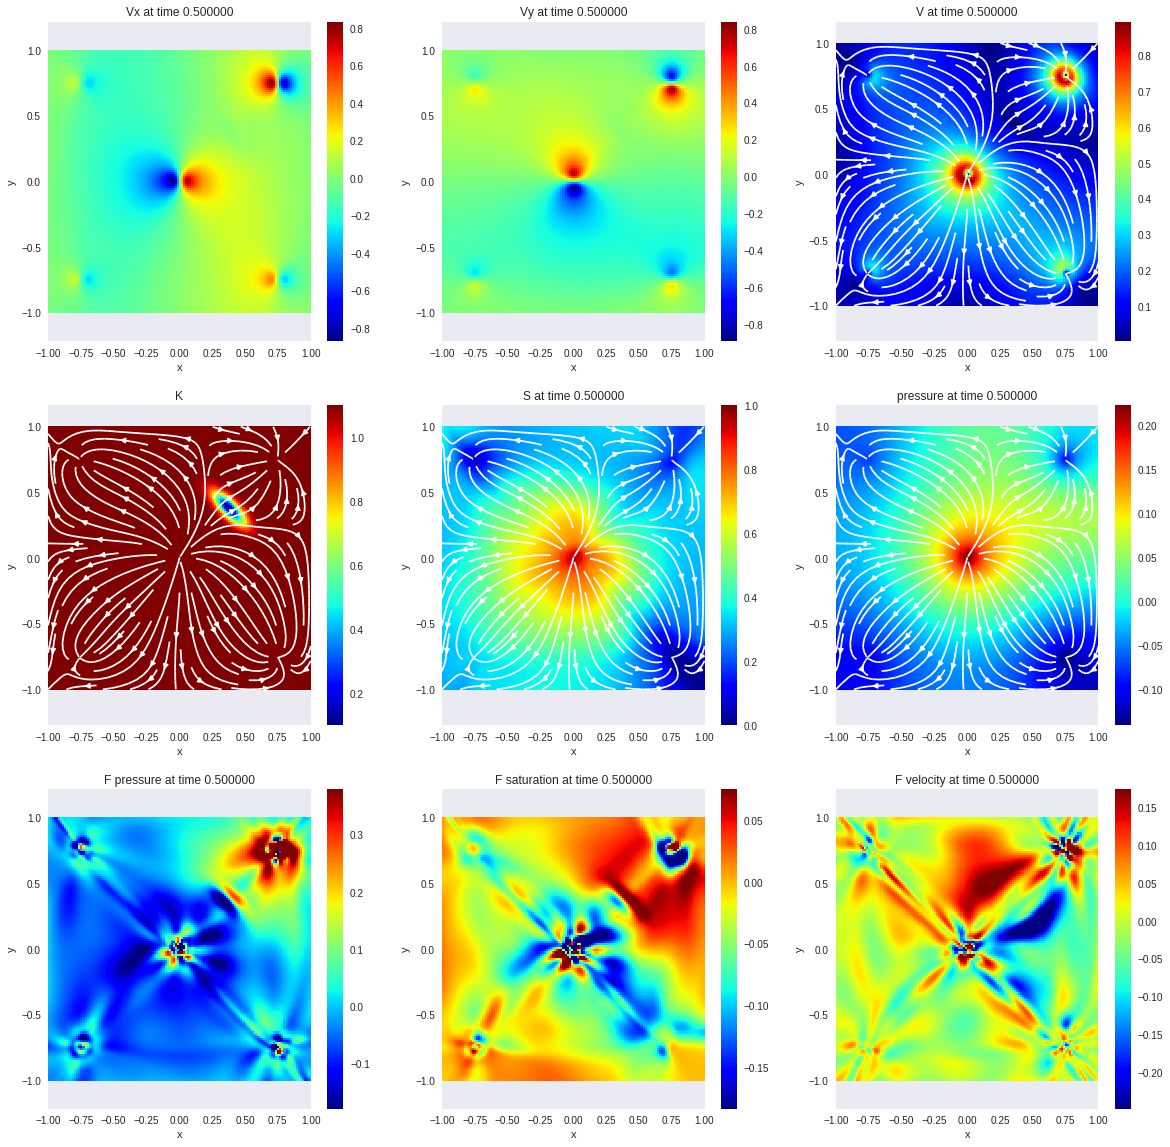

It: 0, Loss: 2.692e-02, Time: 0.29
It: 50, Loss: 2.678e-02, Time: 8.47
Iter: 00050, Loss: 2.62e-02, s: 7.893e-03, vx: 8.082e-04, vy: 9.687e-04, fp: 8.804e-03, fs: 5.835e-03, fv: 1.930e-03
Iter: 00100, Loss: 2.59e-02, s: 7.854e-03, vx: 7.736e-04, vy: 9.573e-04, fp: 8.669e-03, fs: 5.720e-03, fv: 1.911e-03
Iter: 00150, Loss: 2.56e-02, s: 7.798e-03, vx: 8.238e-04, vy: 9.535e-04, fp: 8.473e-03, fs: 5.694e-03, fv: 1.827e-03
Iter: 00200, Loss: 2.52e-02, s: 7.529e-03, vx: 8.933e-04, vy: 8.580e-04, fp: 8.454e-03, fs: 5.687e-03, fv: 1.799e-03
Iter: 00250, Loss: 2.49e-02, s: 7.416e-03, vx: 9.023e-04, vy: 8.354e-04, fp: 8.324e-03, fs: 5.579e-03, fv: 1.803e-03
Iter: 00300, Loss: 2.45e-02, s: 7.280e-03, vx: 8.752e-04, vy: 8.216e-04, fp: 8.181e-03, fs: 5.465e-03, fv: 1.849e-03
Iter: 00350, Loss: 2.41e-02, s: 7.086e-03, vx: 8.457e-04, vy: 8.737e-04, fp: 8.204e-03, fs: 5.345e-03, fv: 1.773e-03
Iter: 00400, Loss: 2.38e-02, s: 6.904e-03, vx: 8.248e-04, vy: 8.050e-04, fp: 8.185e-03, fs: 5.277e-03, fv: 1.8

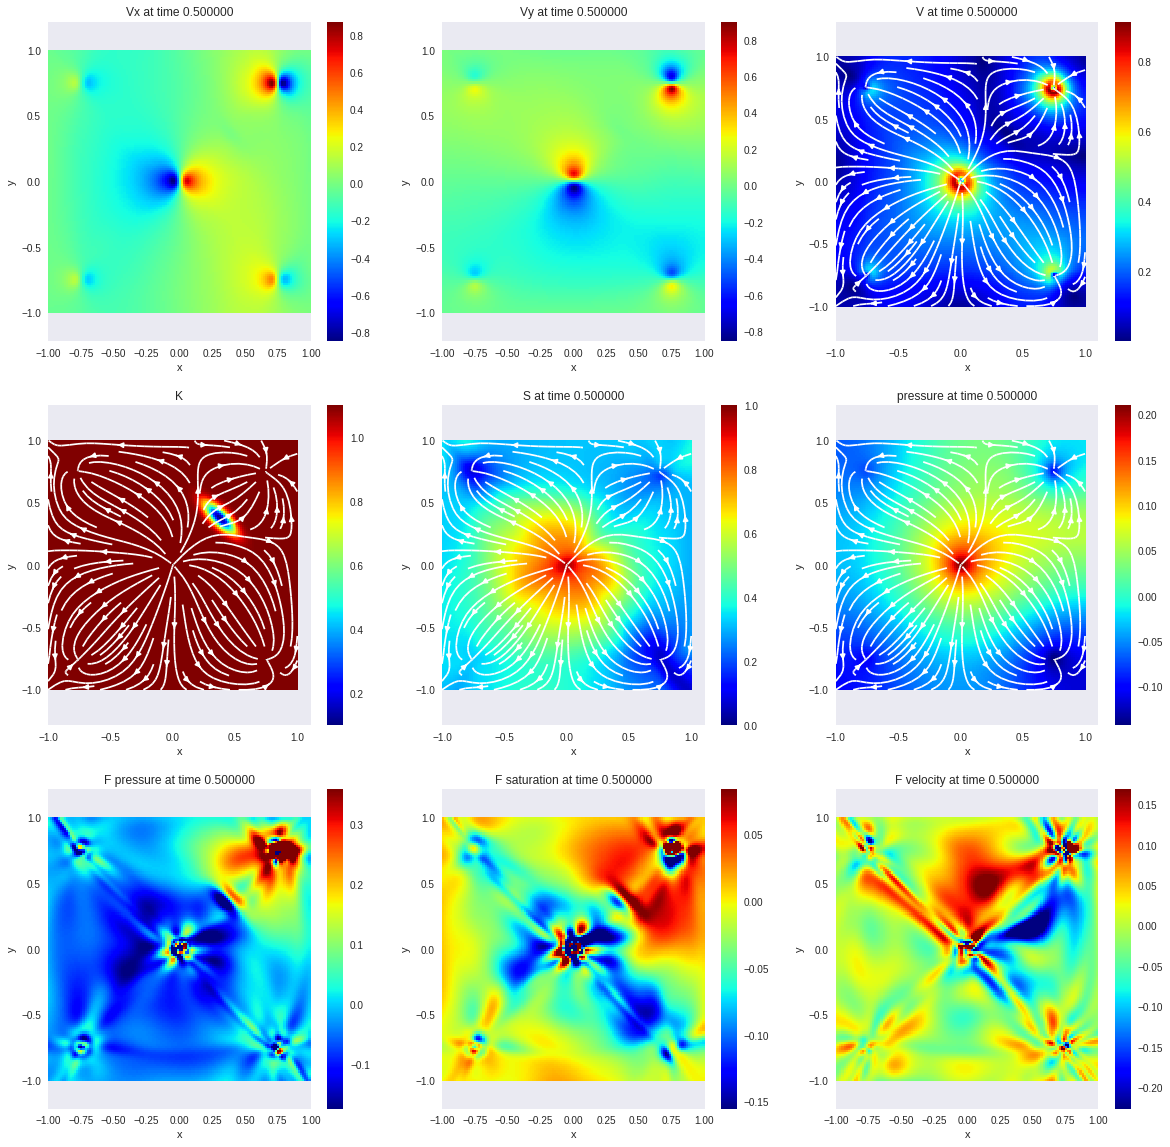

It: 0, Loss: 2.280e-02, Time: 0.28
It: 50, Loss: 2.328e-02, Time: 8.40
Iter: 00050, Loss: 2.24e-02, s: 6.141e-03, vx: 7.256e-04, vy: 8.399e-04, fp: 8.045e-03, fs: 5.059e-03, fv: 1.618e-03
Iter: 00100, Loss: 2.22e-02, s: 6.245e-03, vx: 7.556e-04, vy: 7.737e-04, fp: 7.929e-03, fs: 4.967e-03, fv: 1.573e-03
Iter: 00150, Loss: 2.21e-02, s: 6.134e-03, vx: 7.758e-04, vy: 7.743e-04, fp: 7.930e-03, fs: 4.940e-03, fv: 1.506e-03
Iter: 00200, Loss: 2.18e-02, s: 6.151e-03, vx: 7.617e-04, vy: 7.499e-04, fp: 7.781e-03, fs: 4.872e-03, fv: 1.533e-03
Iter: 00250, Loss: 2.16e-02, s: 6.049e-03, vx: 7.502e-04, vy: 7.494e-04, fp: 7.767e-03, fs: 4.834e-03, fv: 1.494e-03
Iter: 00300, Loss: 2.14e-02, s: 5.876e-03, vx: 7.436e-04, vy: 6.785e-04, fp: 7.803e-03, fs: 4.804e-03, fv: 1.499e-03
Iter: 00350, Loss: 2.12e-02, s: 5.703e-03, vx: 6.673e-04, vy: 7.225e-04, fp: 7.776e-03, fs: 4.788e-03, fv: 1.507e-03
Iter: 00400, Loss: 2.09e-02, s: 5.415e-03, vx: 6.728e-04, vy: 7.295e-04, fp: 7.803e-03, fs: 4.699e-03, fv: 1.5

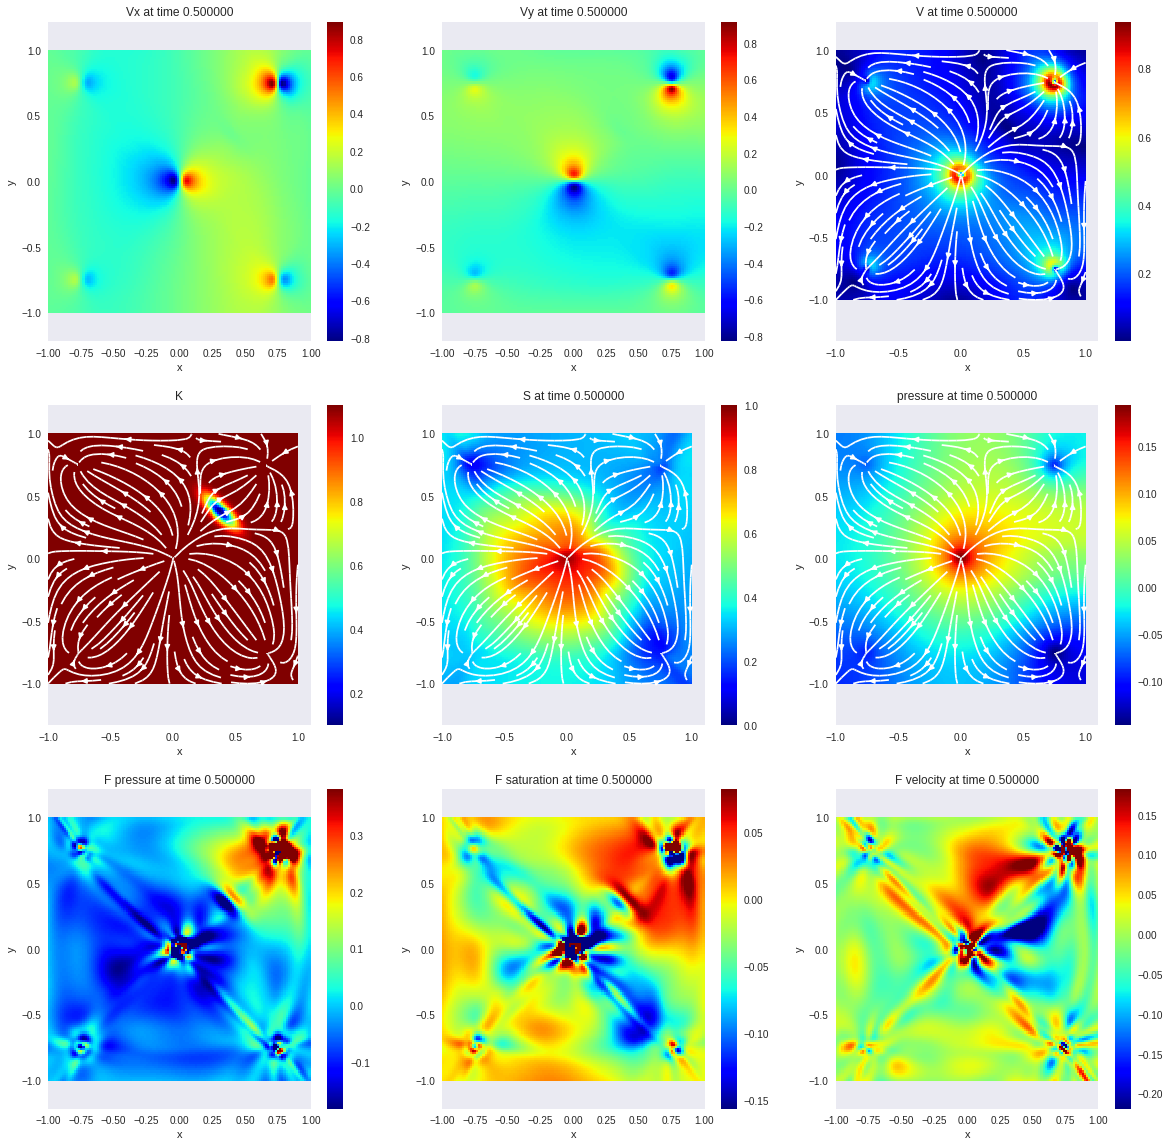

It: 0, Loss: 2.133e-02, Time: 0.25
It: 50, Loss: 1.973e-02, Time: 8.46
Iter: 00050, Loss: 1.91e-02, s: 4.430e-03, vx: 6.649e-04, vy: 6.903e-04, fp: 7.702e-03, fs: 4.142e-03, fv: 1.496e-03
Iter: 00100, Loss: 1.88e-02, s: 4.375e-03, vx: 6.659e-04, vy: 6.717e-04, fp: 7.524e-03, fs: 4.065e-03, fv: 1.482e-03
Iter: 00150, Loss: 1.85e-02, s: 4.335e-03, vx: 6.604e-04, vy: 6.207e-04, fp: 7.405e-03, fs: 3.939e-03, fv: 1.507e-03
Iter: 00200, Loss: 1.82e-02, s: 4.233e-03, vx: 6.998e-04, vy: 6.410e-04, fp: 7.287e-03, fs: 3.848e-03, fv: 1.473e-03
Iter: 00250, Loss: 1.79e-02, s: 4.096e-03, vx: 7.159e-04, vy: 6.505e-04, fp: 7.179e-03, fs: 3.779e-03, fv: 1.496e-03
Iter: 00300, Loss: 1.77e-02, s: 4.048e-03, vx: 6.957e-04, vy: 6.687e-04, fp: 7.157e-03, fs: 3.707e-03, fv: 1.455e-03
Iter: 00350, Loss: 1.75e-02, s: 3.881e-03, vx: 6.489e-04, vy: 6.419e-04, fp: 7.255e-03, fs: 3.615e-03, fv: 1.477e-03
Iter: 00400, Loss: 1.73e-02, s: 3.798e-03, vx: 6.370e-04, vy: 6.640e-04, fp: 7.149e-03, fs: 3.543e-03, fv: 1.5

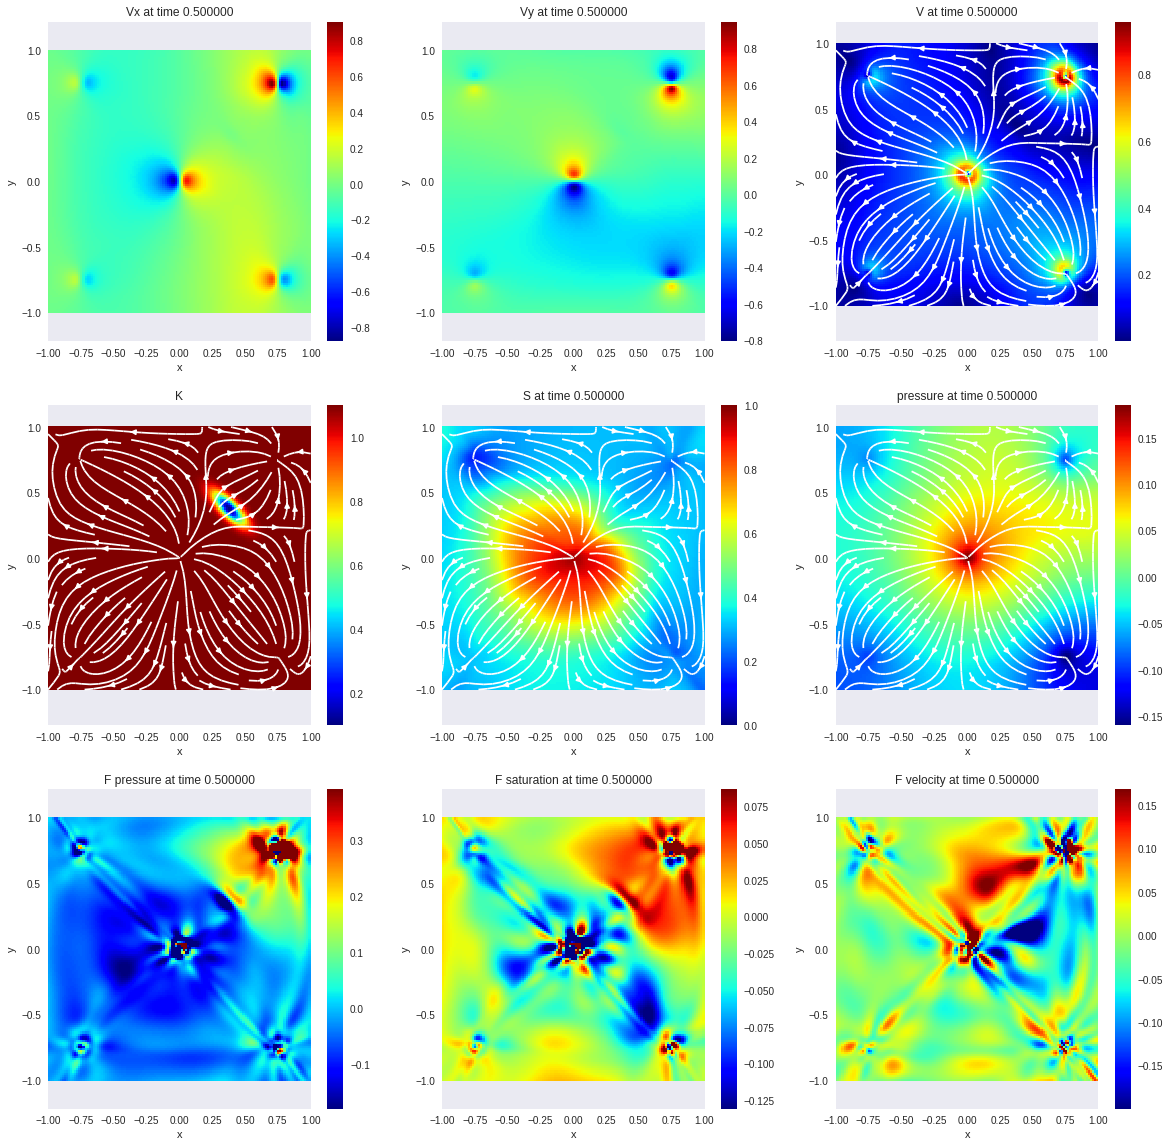

It: 0, Loss: 5.821e-02, Time: 0.26
It: 50, Loss: 1.659e-02, Time: 8.41
Iter: 00050, Loss: 1.61e-02, s: 3.316e-03, vx: 5.991e-04, vy: 6.512e-04, fp: 7.031e-03, fs: 3.085e-03, fv: 1.396e-03
Iter: 00100, Loss: 1.59e-02, s: 3.272e-03, vx: 6.197e-04, vy: 6.510e-04, fp: 6.908e-03, fs: 3.048e-03, fv: 1.360e-03
Iter: 00150, Loss: 1.57e-02, s: 3.248e-03, vx: 5.992e-04, vy: 6.105e-04, fp: 6.933e-03, fs: 2.997e-03, fv: 1.324e-03
Iter: 00200, Loss: 1.55e-02, s: 3.213e-03, vx: 5.819e-04, vy: 6.320e-04, fp: 6.838e-03, fs: 2.967e-03, fv: 1.295e-03
Iter: 00250, Loss: 1.53e-02, s: 3.058e-03, vx: 6.177e-04, vy: 5.978e-04, fp: 6.781e-03, fs: 2.954e-03, fv: 1.330e-03
Iter: 00300, Loss: 1.51e-02, s: 2.998e-03, vx: 6.182e-04, vy: 5.476e-04, fp: 6.747e-03, fs: 2.893e-03, fv: 1.335e-03
Iter: 00350, Loss: 1.49e-02, s: 2.800e-03, vx: 5.445e-04, vy: 5.965e-04, fp: 6.775e-03, fs: 2.816e-03, fv: 1.364e-03
Iter: 00400, Loss: 1.46e-02, s: 2.595e-03, vx: 5.730e-04, vy: 5.482e-04, fp: 6.752e-03, fs: 2.734e-03, fv: 1.3

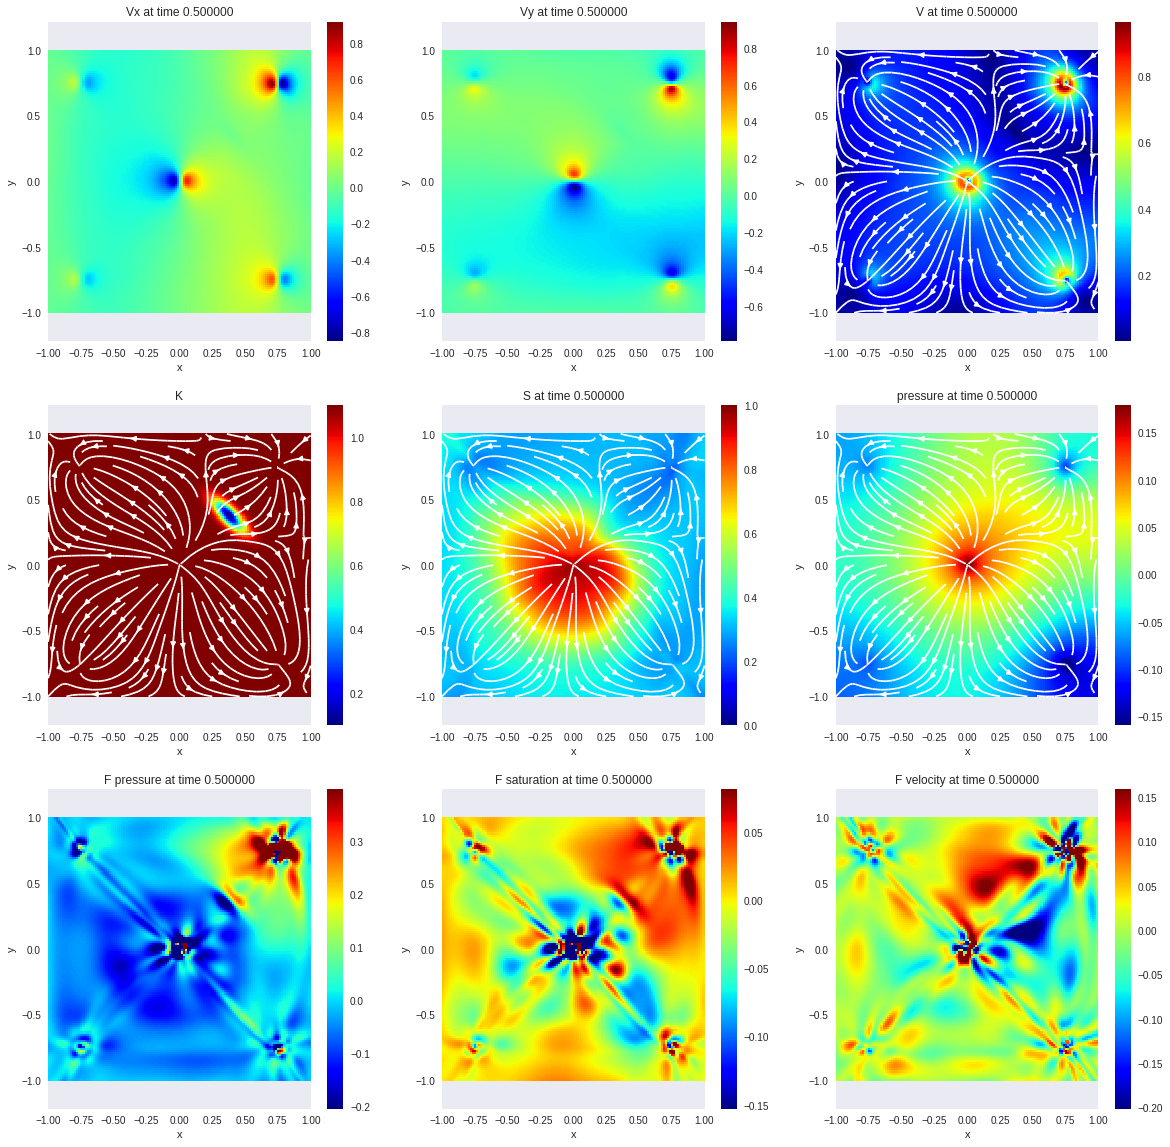

It: 0, Loss: 1.353e-02, Time: 0.30
It: 50, Loss: 1.435e-02, Time: 8.40
Iter: 00050, Loss: 1.32e-02, s: 2.100e-03, vx: 5.617e-04, vy: 5.698e-04, fp: 6.441e-03, fs: 2.221e-03, fv: 1.352e-03
Iter: 00100, Loss: 1.31e-02, s: 2.086e-03, vx: 5.566e-04, vy: 5.497e-04, fp: 6.403e-03, fs: 2.161e-03, fv: 1.304e-03
Iter: 00150, Loss: 1.29e-02, s: 2.042e-03, vx: 5.205e-04, vy: 5.366e-04, fp: 6.401e-03, fs: 2.150e-03, fv: 1.260e-03
Iter: 00200, Loss: 1.27e-02, s: 2.033e-03, vx: 5.337e-04, vy: 5.336e-04, fp: 6.313e-03, fs: 2.096e-03, fv: 1.236e-03
Iter: 00250, Loss: 1.26e-02, s: 1.997e-03, vx: 5.478e-04, vy: 5.275e-04, fp: 6.267e-03, fs: 2.050e-03, fv: 1.222e-03
Iter: 00300, Loss: 1.25e-02, s: 1.924e-03, vx: 5.591e-04, vy: 5.405e-04, fp: 6.189e-03, fs: 2.022e-03, fv: 1.222e-03
Iter: 00350, Loss: 1.23e-02, s: 1.846e-03, vx: 5.393e-04, vy: 5.737e-04, fp: 6.191e-03, fs: 1.950e-03, fv: 1.191e-03
Iter: 00400, Loss: 1.22e-02, s: 1.801e-03, vx: 5.197e-04, vy: 5.482e-04, fp: 6.205e-03, fs: 1.882e-03, fv: 1.2

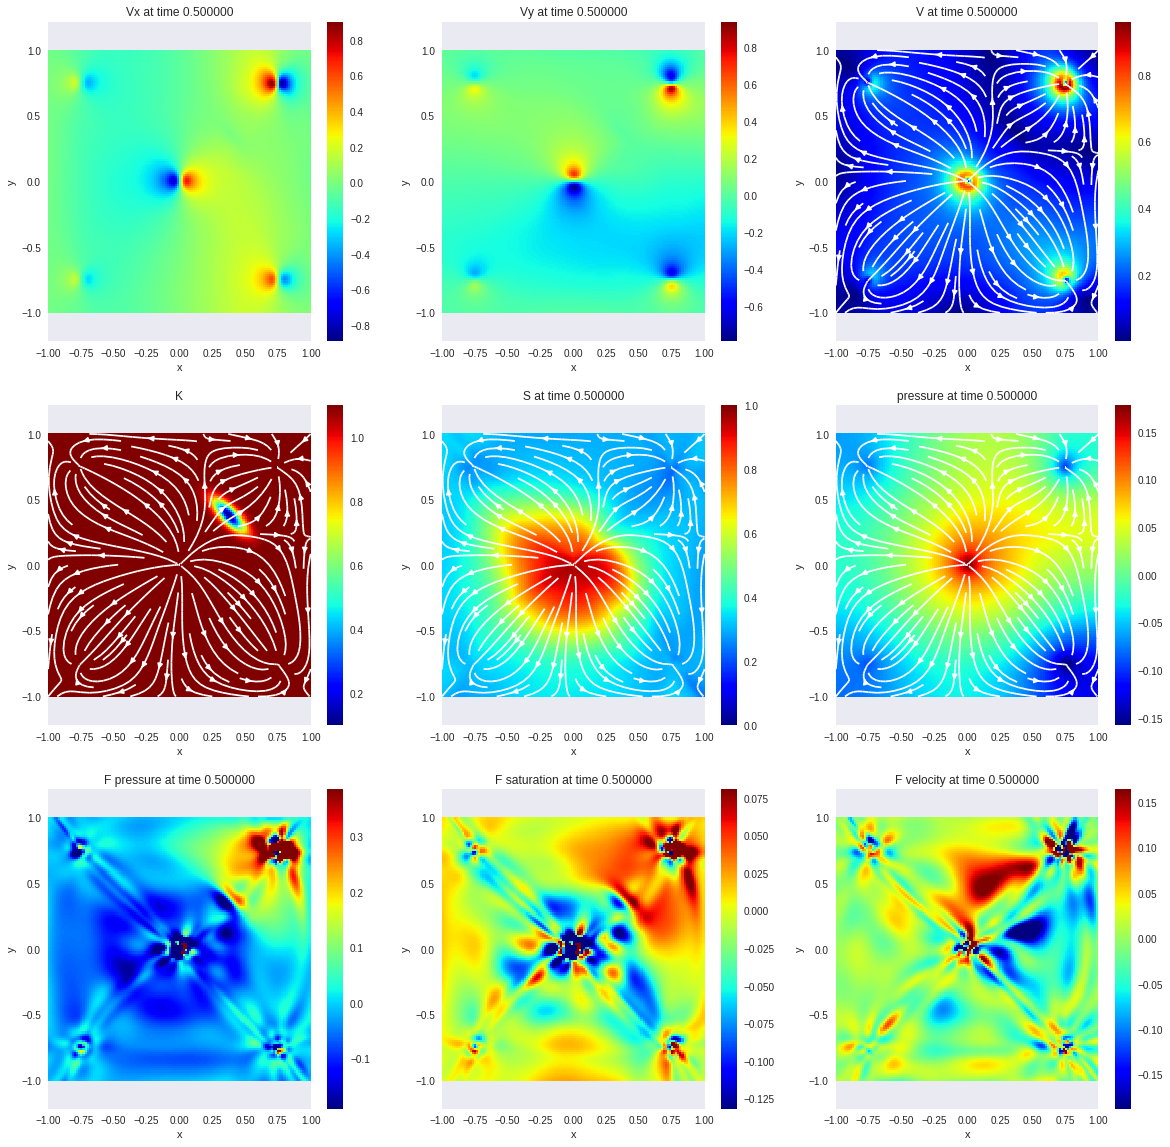

In [12]:
for i in range(10):
    start_time = time.time()
    #if i<3:
    #    model.train(500)
    #else:
    model.train(100)
    elapsed = time.time() - start_time
    print('Training time: %.4f' % (elapsed))
    draw_prediction(0.5)

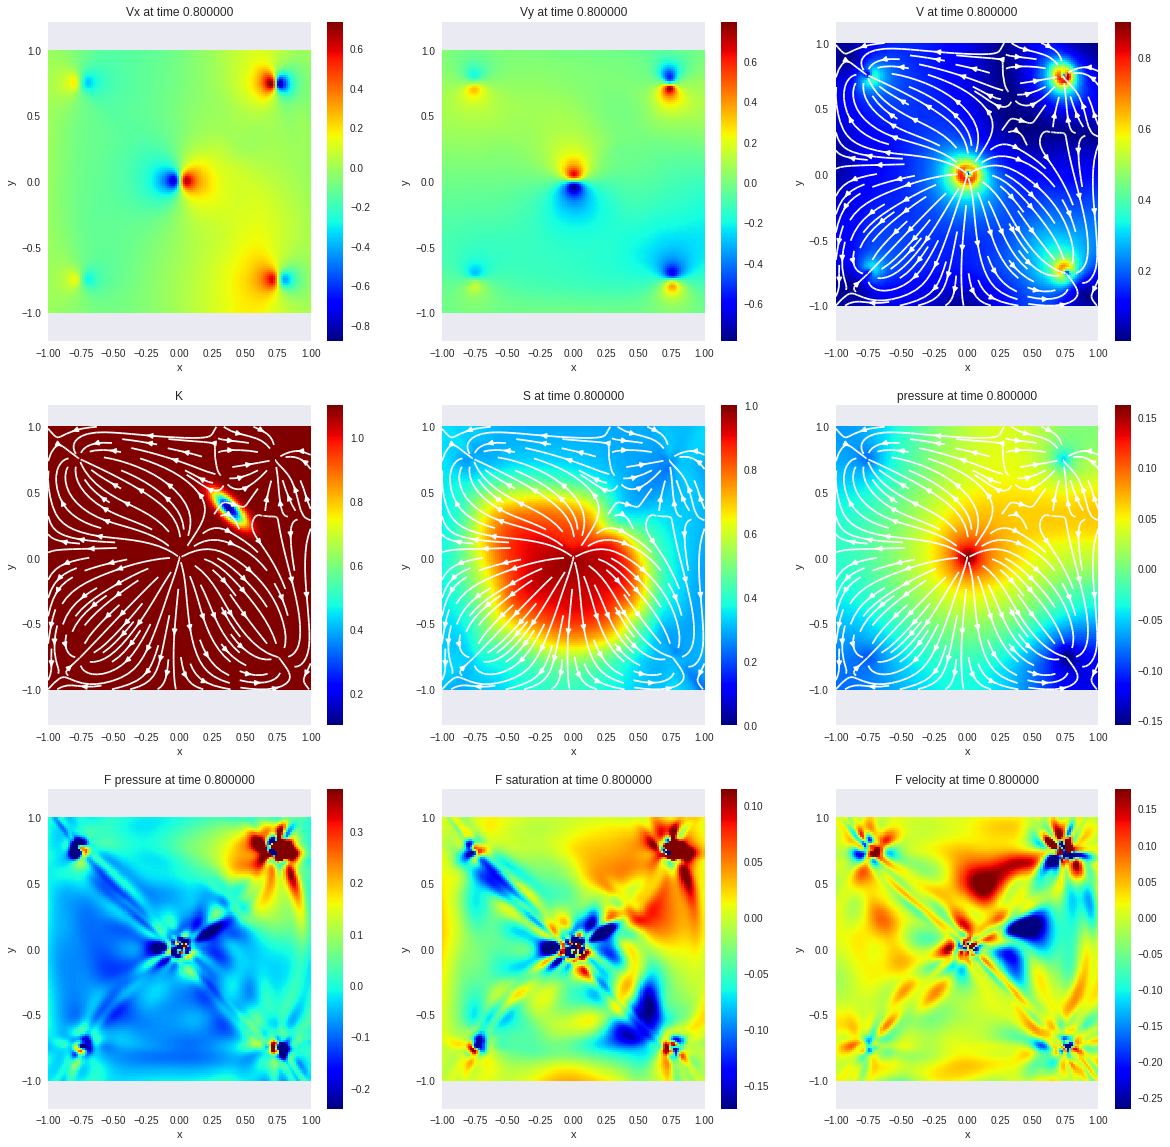

In [17]:
draw_prediction(0.8)

In [0]:
saver = tf.train.Saver()
save_path = saver.save(model.sess, "data/dm.ckpt")

In [19]:
import os
print( os.getcwd() )
print( os.listdir('data') )

/content
['dm.ckpt.meta', 'dm.ckpt.data-00000-of-00001', 'dm.ckpt.index', 'checkpoint']


In [0]:
from google.colab import files
files.download( "data/dm.ckpt.meta" ) 